In [1]:
include("TidalLoveNumbersPorousK23fast.jl")
using .TidalLoveNumbers
using DoubleFloats
using PyPlot
using Statistics
using PyCall
using BenchmarkTools
    
@pyimport seaborn as sns
@pyimport matplotlib as mpl
@pyimport matplotlib.gridspec as gspec
#
PyPlot.isjulia_display[] = false;

PyPlot.matplotlib[:rc]("font",family="Arial", weight="medium", style="normal", size=12)
PyPlot.matplotlib[:rc]("axes",titlesize=14.5, labelsize=12, unicode_minus=false)
PyPlot.matplotlib[:rc]("xtick",labelsize=11.5)
PyPlot.matplotlib[:rc]("ytick",labelsize=11.5)
PyPlot.matplotlib[:rc]("pdf",fonttype=42)
PyPlot.matplotlib[:rc]("mathtext", fontset = "stix")

mpl.style.use("dark_background")

prec = TidalLoveNumbers.prec
precc = TidalLoveNumbers.precc

Complex{Double64}

In [48]:
non_dim = false

G = prec(6.6743e-11)
e = 0.0041

h_core = 1500.0
h_mantle_low = 1880.0
h_mantle_up = 50.0

h_crust = 20.
ω0 = 2pi/(24.6*60*60 - 0.318*60*60)
ω = ω0

#enceladus test model:
n = 2
ρₛ = [7000, 3300, 3300, prec(3300)]
r = [0, 
     h_core, 
     h_core+h_mantle_low, 
     h_core+h_mantle_low+h_mantle_up, 
     h_core+h_mantle_low+h_mantle_up+h_crust] .* 1e3
μ = [60+0im, 60, 60, prec(60)] .* 1e9
κ = [100e9, 100e9, 100e9, 100e9] .* 1000000.0
η = [1e25, 1e25, 1e25, 1e25]

R = r[end]
μ0 = μ[end]
bp = 3
tp = 3


ρₗ = [0, 0, 1000, 0]
α  = [0, 0, 0.99, 0]
κₗ = [0, 0, 10000e9, 0] 
# α = 0.95
κd = (1 .- α).*κ
k = [0, 0, 1e-7, 0]

ηₗ = [0, 0, 2e-3, 0]
ϕ =  [0, 0, prec(0.2), 0]

ρ = (1 .- ϕ) .* ρₛ + ϕ .* ρₗ # bulk density
# ρ = ρₛ
r = expand_layers(r)
g = get_g(r, ρ);


In [32]:
res = 10.0
lons = deg2rad.(collect(0:res:360-0.001))'
clats = deg2rad.(collect(0:res:180))

lons_deg = rad2deg.(lons[:])
lats_deg = 90 .- rad2deg.(clats)
dres = deg2rad(res);

# Total Heating

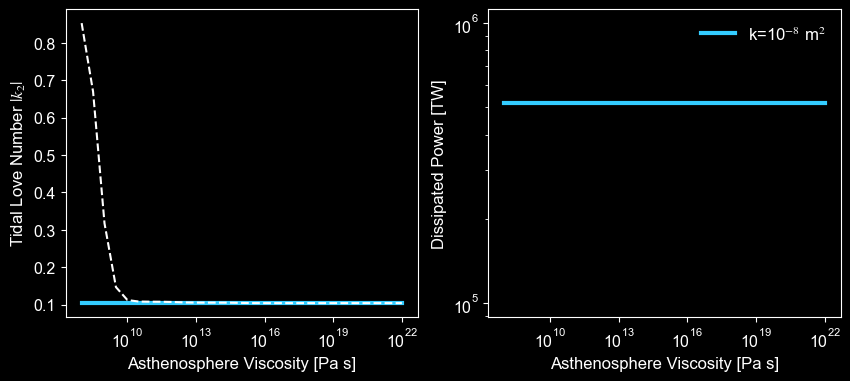

In [49]:
ηs = 8:0.5:22

res = 10.0
lons = deg2rad.(collect(0:res:360-0.001))'
clats = deg2rad.(collect(0:res:180))

lons_deg = rad2deg.(lons[:])
lats_deg = 90 .- rad2deg.(clats)
dres = deg2rad(res)

fig, axes = plt.subplots(ncols=2, figsize=(10,4))
# println(size(axes))

colors = ["C1", "C2", "C3", "C4"]
cmap = PyPlot.cm.cool
colors = [0.2, 0.4, 0.6, 0.8]
cnt = 1
for j in -8:1:-8
    Edot = zeros(length(ηs))
    Edots = zeros(length(ηs))
    k_ln = zeros(ComplexF64, length(ηs))
    k_lns = zeros(ComplexF64, length(ηs))
    for i in eachindex(ηs)
        #######################################################################
        η[3] = 10.0^ηs[i] * (non_dim ? 1.0/(μ0*T) : 1.0)

        # k = 10^-j * eta_l 
        k[3] = 10.0^j * (non_dim ? 1.0/R^2 : 1.0)

        μc =  1im*ω*μ ./ (1im*ω .+ μ ./ η)

        # μc = μ

        y = calculate_y(r, ρ, g, μ, κ, ω, ρₗ, κₗ,κd, α, ηₗ, ϕ, k)
        # y = calculate_y(r, ρ, g, μc, κ, ω, ρₗ, κₗ, κd, α, ηₗ, ϕ, k)
        y2 = calculate_y(r, ρ, g, μc, κ)

        # display(y)

        yR = y[end,end]
        yR2 = y2[end,end]

        k2 = yR[5] - 1
        k22 = yR2[5] - 1

        k_ln[i] = k2
        k_lns[i] = k22
    
        # println(k2)

        # k2_2[i] = k2    # println("Porous body k2 = ", k2)  
        # println("k2 = ", yR[5] - 1)  
        # println("h2 = ", -g[end]*yR[1] )
        Edot[i] = 21/2 * -imag(k2) * (ω0*R)^5/G * e^2
        Edots[i] = 21/2 * -imag(k22) * (ω0*R)^5/G * e^2
        # println("Dissipated Energy Total: ", Ediss2/1e9)

       

    end

    axes[1].semilogx(10.0 .^ collect(ηs), abs.(k_ln), label="k=10\$^{$(j)}\$ m\$^{2}\$", color=cmap(colors[cnt]), lw=3.0)
    axes[1].semilogx(10.0 .^ collect(ηs), abs.(k_lns), "w--")

    axes[2].loglog(10.0 .^ collect(ηs), -abs.(k_ln)./imag.(k_ln), label="k=10\$^{$(j)}\$ m\$^{2}\$", color=cmap(colors[cnt]), lw=3.0)
    
    # if j == -4 
    #     axes[2].loglog(10.0 .^ collect(ηs), Edots/1e12, "w--", label="no melt")
    # else
    #     axes[2].loglog(10.0 .^ collect(ηs), Edots/1e12, "w--")
    # end

    cnt += 1
end

axes[2].legend(frameon=false)

axes[1].set_ylabel("Tidal Love Number \$|k_2|\$")
axes[2].set_ylabel("Dissipated Power [TW]")
axes[1].set_xlabel("Asthenosphere Viscosity [Pa s]")
axes[2].set_xlabel("Asthenosphere Viscosity [Pa s]")

# axes[2].axhspan((9.33-1.87)*1e13/1e12, (9.33+1.87)*1e13/1e12, alpha=0.8)
# axes[1].set_ylim([0,1.3])
# fig.savefig("edot_-6.pdf", bbox_inches="tight", transparent=true, dpi=350)
display(fig)

